In [35]:
library(tidyverse)
library(broom)
library(janitor)
library(ggforce)
library(arcadiathemeR)

## Calculate Kozak sequence scores for all transcripts in the human transcriptome and all sORFs predicted by peptigate

The Kozak consensus sequence functions as a translation initiation start site and enhances the efficiency of translation by directing ribosomes to the correct start codon [https://doi.org/10.1093/nar/15.20.8125].
It occurs six basepairs upstream and one basepair downstream of the start codon in a transcript [https://doi.org/10.1093/nar/15.20.8125].
The exact sequence varies so each Kozak sequence can be scored in comparison to the most common sequence motif [https://doi.org/10.1186/s13059-017-1222-2].
We scored each Kozak sequence as performed in [https://doi.org/10.1186/s13059-017-1222-2]: using the sequence motif GccA/GccAUGG, we designated upper-case letters as highly conserved (scored +3) and lower-case letters as common (scored +1).
We did not score the start codon (bolded letters).
The maximum score is 13.

First calculate the Kozak sequence scores for the full human transcriptome.

In [4]:
command <- paste(
    "python ../../scripts/calculate_all_kozak_scores.py",
    "--transcript ../../peptigate/running_peptigate/GCF_000001405.40_GRCh38.p14_rna.fna",
    "--orf ../../peptigate/running_peptigate/GCF_000001405.40_GRCh38.p14_rna.fna.transdecoder.cds",
    "--output GCF_000001405.40_GRCh38.p14_rna_kozak_scores.tsv",
    "--tool transdecoder",
    sep = " \\\n"
)
system(command, intern = TRUE)

[1] "Results written to GCF_000001405.40_GRCh38.p14_rna_kozak_scores.tsv"

Next, calculate the Kozak sequences scores for the sORFs.
We'll have to go back to the transcriptome and extract the sORF transcripts; plm-utils only outputs the sORF sequences, not the full transcripts.

In [5]:
command <- paste(
  "seqkit grep",
  "--pattern-file ../../peptigate/results/sORF/plmutils/plmutils_peptide_names.faa",
  "-o sorf_transcripts.fa",
  "../../peptigate/running_peptigate/GCF_000001405.40_GRCh38.p14_rna.fna",
  sep = " \\\n"
)

system(command, intern = TRUE)

character(0)

In [6]:
system("gunzip ../../peptigate/results/predictions/peptides.ffn.gz")

In [7]:
command <- paste(
    "python ../../scripts/calculate_all_kozak_scores.py",
    "--transcript sorf_transcripts.fa",
    "--orf ../../peptigate/results/predictions/peptides.ffn",
    "--output sorf_kozak_scores.tsv",
    "--tool orfipy",
    sep = " \\\n"
)
system(command, intern = TRUE)

[1] "Results written to sorf_kozak_scores.tsv"

## Analyze the Kozak sequence scores

In [12]:
sorf_kozak <- read_tsv("sorf_kozak_scores.tsv", show_col_types = FALSE) %>%
  clean_names() %>%
  filter(!is.na(kozak_score)) %>%
  mutate(origin = "sORF") %>%
  mutate(transcript_type = gsub("_.*", "", name),
         transcript_type_description = ifelse(transcript_type == "NM", "Coding",
                                              ifelse(transcript_type == "NR", "Noncoding", "Miscellaneous")))

In [13]:
all_kozak <- read_tsv("GCF_000001405.40_GRCh38.p14_rna_kozak_scores.tsv", show_col_types = FALSE) %>%
  clean_names() %>%
  filter(type == "complete") %>%
  filter(!is.na(kozak_score)) %>%
  mutate(origin = "All") %>%
  mutate(transcript_type = gsub("_.*", "", name),
         transcript_type_description = ifelse(transcript_type == "NM", "Coding",
                                              ifelse(transcript_type == "NR", "Noncoding", "Miscellaneous")))

In [14]:
kozak <- bind_rows(sorf_kozak, all_kozak)

In [15]:
quantiles_df <- kozak %>%
  group_by(origin) %>%
  summarise(
    Q25 = round(quantile(kozak_score, probs = 0.25, na.rm = TRUE), digits = 2),
    Median = round(quantile(kozak_score, probs = 0.50, na.rm = TRUE), digits = 2),
    Q75 = round(quantile(kozak_score, probs = 0.75, na.rm = TRUE), digits = 2)
  )

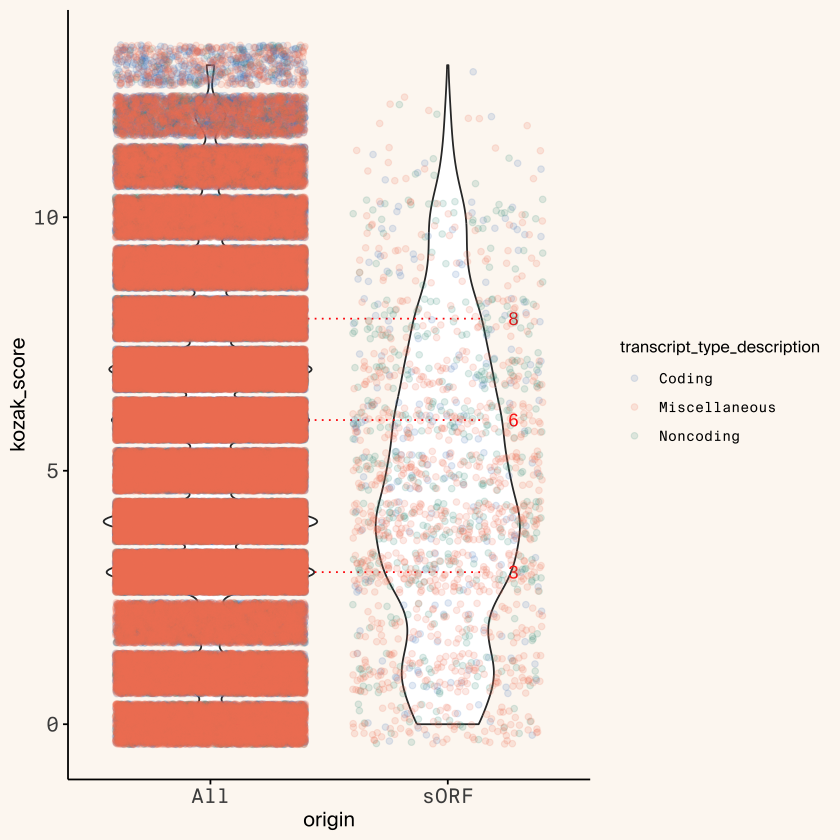

In [42]:
ggplot(kozak, aes(y = kozak_score, x = origin)) +
  geom_violin() +
  geom_segment(data = quantiles_df %>% filter(origin == "All"), 
               aes(x = 0.75, xend = 2.15, y = Q25, yend = Q25),
               linetype = "dotted", color = "red") +
  geom_segment(data = quantiles_df %>% filter(origin == "All"), 
               aes(x = 0.75, xend = 2.15, y = Median, yend = Median),
               linetype = "dotted", color = "red") +
  geom_segment(data = quantiles_df %>% filter(origin == "All"), 
               aes(x = 0.75, xend = 2.15, y = Q75, yend = Q75),
               linetype = "dotted", color = "red") +
  geom_text(data = quantiles_df %>% filter(origin == "All"), 
            aes(x = 2.32, y = Q25, label = Q25), hjust = 1.5, color = "red") +
  geom_text(data = quantiles_df %>% filter(origin == "All"), 
            aes(x = 2.32, y = Median, label = Median), hjust = 1.5, color = "red") +
  geom_text(data = quantiles_df %>% filter(origin == "All"), 
            aes(x = 2.32, y = Q75, label = Q75), hjust = 1.5, color = "red") +
  theme_arcadia() +
  geom_jitter(aes(color = transcript_type_description), alpha = 0.15) +
  scale_color_arcadia()

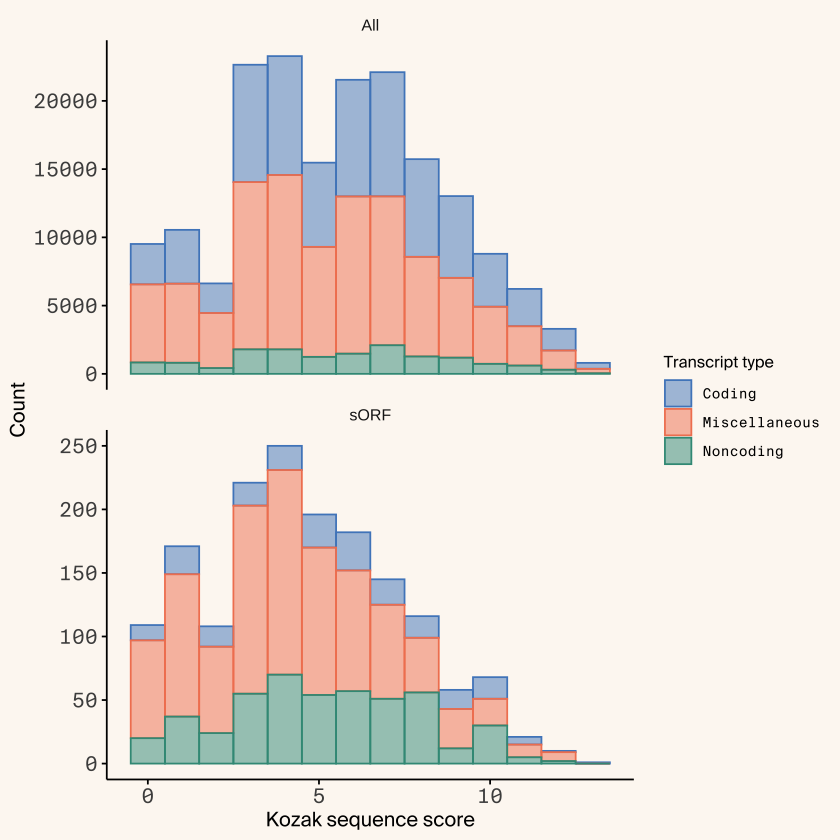

In [41]:
ggplot(kozak, aes(x = kozak_score, fill = transcript_type_description, color = transcript_type_description)) +
  geom_histogram(alpha = .5, bins = 14) +
  facet_wrap(~origin, nrow = 2, scales = "free_y") +
  theme_arcadia() +
  labs(x = "Kozak sequence score", y = "Count", fill = "Transcript type", color = "Transcript type") +
  scale_fill_arcadia() +
  scale_color_arcadia()

In [19]:
results <- kozak %>%
  group_by(transcript_type_description) %>%
  group_map(~ tidy(t.test(kozak_score ~ origin, data = .x)), .keep = TRUE) %>%
  bind_rows()
results

estimate,estimate1,estimate2,statistic,p.value,parameter,conf.low,conf.high,method,alternative
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
0.5272235,5.827223,5.300000,2.507305,1.288730e-02,220.2606,0.1128152,0.9416317,Welch Two Sample t-test,two.sided
1.1163903,5.302268,4.185877,12.810614,7.228141e-35,987.0200,0.9453782,1.2874025,Welch Two Sample t-test,two.sided
0.5359408,5.681818,5.145877,4.153597,3.836007e-05,510.7937,0.2824449,0.7894367,Welch Two Sample t-test,two.sided


In [20]:
t_test_result <- t.test(kozak_score ~ origin, data = kozak)

# Use broom to tidy the t-test result
tidy_result <- tidy(t_test_result)
tidy_result

estimate,estimate1,estimate2,statistic,p.value,parameter,conf.low,conf.high,method,alternative
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
0.9354612,5.543553,4.608092,13.4812,2.030383e-39,1690.595,0.7993617,1.071561,Welch Two Sample t-test,two.sided


In [22]:
kozak %>% group_by(origin, transcript_type_description) %>% 
  summarize(mean_ks = mean(kozak_score),
            sd_ks = sd(kozak_score),
            median_ks = median(kozak_score)) %>%
  arrange(transcript_type_description)

`summarise()` has grouped output by 'origin'. You can override using the `.groups` argument.


origin,transcript_type_description,mean_ks,sd_ks,median_ks
<chr>,<chr>,<dbl>,<dbl>,<dbl>
All,Coding,5.827223,3.019632,6
sORF,Coding,5.300000,3.114409,5
All,Miscellaneous,5.302268,3.001583,5
sORF,Miscellaneous,4.185877,2.687023,4
All,Noncoding,5.681818,3.074470,6
sORF,Noncoding,5.145877,2.751323,5


## Compare within sORFs

Within sORFs, some are demarcated as coding transcripts in the reference transcriptome.
Compare mean values within just sORFs.

In [23]:
tmp1 <- sorf_kozak %>%
  filter(transcript_type_description != "Miscellaneous")
t.test(kozak_score ~ transcript_type_description, data = tmp1)


	Welch Two Sample t-test

data:  kozak_score by transcript_type_description
t = 0.62872, df = 383.41, p-value = 0.5299
alternative hypothesis: true difference in means between group Coding and group Noncoding is not equal to 0
95 percent confidence interval:
 -0.3278603  0.6361056
sample estimates:
   mean in group Coding mean in group Noncoding 
               5.300000                5.145877 


In [24]:
tmp2 <- sorf_kozak %>%
  filter(transcript_type_description != "Noncoding")
t.test(kozak_score ~ transcript_type_description, data = tmp2)


	Welch Two Sample t-test

data:  kozak_score by transcript_type_description
t = 4.9053, df = 297.86, p-value = 1.537e-06
alternative hypothesis: true difference in means between group Coding and group Miscellaneous is not equal to 0
95 percent confidence interval:
 0.6671471 1.5610980
sample estimates:
       mean in group Coding mean in group Miscellaneous 
                   5.300000                    4.185877 


## Does the kozak score correlate with plm-utils score?

Plm-utils scores transcripts from 0-1.
By default, transcripts that score over 0.5 are considered coding.
Below we test whether the plm-utils score is correlated with the strength of the Kozak sequence.

In [27]:
plmutils_scores <- read_tsv("../../peptigate/results/predictions/peptide_predictions.tsv.gz", show_col_types = FALSE)

In [29]:
head(sorf_kozak)

name,orf,start,stop,strand,type,length,frame,start_codon,stop_codon,kozak_score,origin,transcript_type,transcript_type_description
<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>
NM_000825.3,NM_000825.3_ORF.11,1698,1986,+,complete,288,1,ATG,TAA,4,sORF,NM,Coding
NM_001001660.3,NM_001001660.3_ORF.3,138,408,+,complete,270,1,ATG,TGA,6,sORF,NM,Coding
NM_001007250.3,NM_001007250.3_ORF.1,27,261,+,complete,234,1,GTG,TAA,1,sORF,NM,Coding
NM_001009181.2,NM_001009181.2_ORF.7,269,449,+,complete,180,3,TTG,TAA,1,sORF,NM,Coding
NM_001011878.3,NM_001011878.3_ORF.1,12,291,+,complete,279,1,CTG,TGA,1,sORF,NM,Coding
NM_001012456.2,NM_001012456.2_ORF.6,64,340,-,complete,276,-1,TTG,TGA,3,sORF,NM,Coding


In [31]:
sorf_plm_kozak <- inner_join(plmutils_scores, sorf_kozak, by = c("peptide_id" = "name")) %>%
  select(peptide_id, plmutils_class_probability, kozak_score, transcript_type, transcript_type_description)

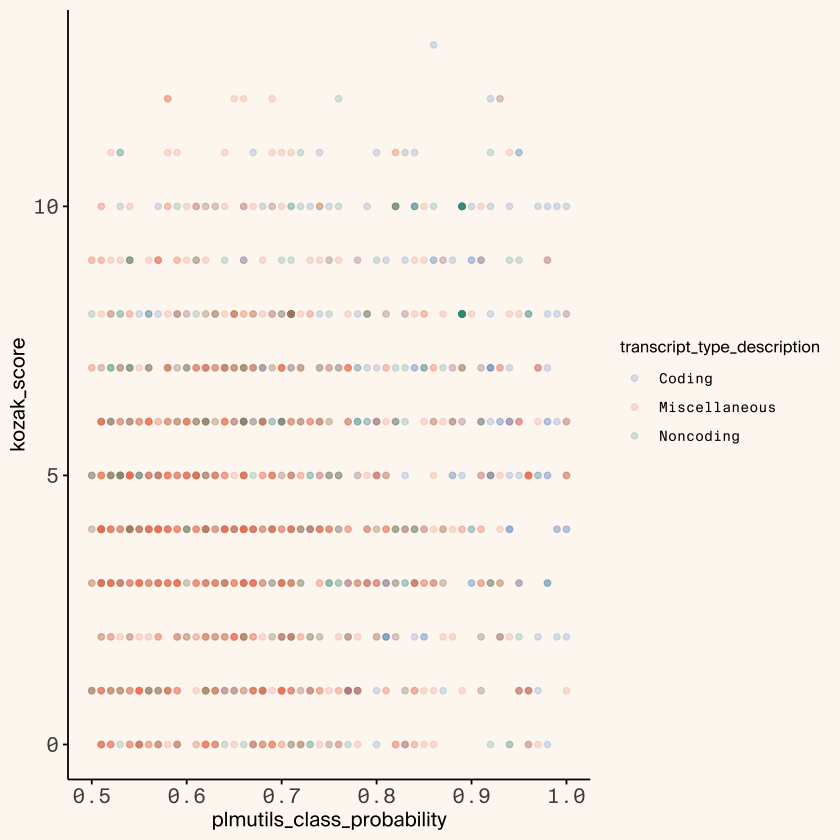

In [40]:
ggplot(sorf_plm_kozak, aes(x = plmutils_class_probability, y = kozak_score, color = transcript_type_description)) +
  geom_point(alpha = 0.2) +
  theme_arcadia() +
  scale_color_arcadia() 

In [33]:
# Linear regression model
model <- lm(kozak_score ~ plmutils_class_probability, data = sorf_plm_kozak)

# Summarize the model to view results
summary(model)


Call:
lm(formula = kozak_score ~ plmutils_class_probability, data = sorf_plm_kozak)

Residuals:
    Min      1Q  Median      3Q     Max 
-5.4893 -2.0624 -0.2392  1.8781  7.8766 

Coefficients:
                           Estimate Std. Error t value Pr(>|t|)    
(Intercept)                  2.5014     0.3624   6.902 7.27e-12 ***
plmutils_class_probability   3.0488     0.5151   5.919 3.92e-09 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 2.78 on 1654 degrees of freedom
Multiple R-squared:  0.02074,	Adjusted R-squared:  0.02015 
F-statistic: 35.04 on 1 and 1654 DF,  p-value: 3.922e-09


In [43]:
sessionInfo()

R version 4.3.3 (2024-02-29)
Platform: x86_64-apple-darwin13.4.0 (64-bit)
Running under: macOS Big Sur ... 10.16

Matrix products: default
BLAS/LAPACK: /Users/taylorreiter/miniconda3/envs/pepeval/lib/libopenblasp-r0.3.26.dylib;  LAPACK version 3.12.0

locale:
[1] en_US.UTF-8/en_US.UTF-8/en_US.UTF-8/C/en_US.UTF-8/en_US.UTF-8

time zone: America/Los_Angeles
tzcode source: internal

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] arcadiathemeR_0.1.0 ggforce_0.4.2       janitor_2.2.0      
 [4] broom_1.0.5         lubridate_1.9.3     forcats_1.0.0      
 [7] stringr_1.5.1       dplyr_1.1.4         purrr_1.0.2        
[10] readr_2.1.5         tidyr_1.3.1         tibble_3.2.1       
[13] ggplot2_3.5.0       tidyverse_2.0.0    

loaded via a namespace (and not attached):
 [1] utf8_1.2.4       generics_0.1.3   stringi_1.8.3    hms_1.1.3       
 [5] digest_0.6.35    magrittr_2.0.3   evaluate_0.23    grid_4.3.3     